# <font color = "red">Classificador de Imagens com Deep Learning e PyTorch

## Definição do Problema

Abaixo estão os tipos de "Problemas" a serem resolvidos com visão computacional, faremos o de classificação de imagens 

![title](CV.jpeg)

In [4]:
!pip install -u tensorflow


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [1]:
# Imports 
import tensorflow
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### <font color = "red">Verificando Disponibilidade de GPU


http://pytorch.org/docs/stable/cuda.html

https://developer.nvidia.com/cuda-zone

Pode ser útil acelerar o tempo de treinamento usando uma GPU. CUDA é uma plataforma da Nvidia que permite usarmos as GPUs (Nvidia) para processamento paralelo). Os frameworks de Deep Learning dependem da plataforma CUDA para o processamento em GPU.

In [3]:
# Executar somente se a máquina tiver GPU e Plataforma CUDA instalada
!nvidia-smi

Wed Nov 27 07:23:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX110         WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0             N/A /  200W |       0MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Verifica se a plataforma CUDA está disponível
train_on_gpu = torch.cuda.is_available()

In [5]:
print("GPUs detectadas:", tensorflow.config.list_physical_devices('GPU'))

GPUs detectadas: []


In [6]:
print("CUDA está disponível:", torch.cuda.is_available())
print("Nome da GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Nenhuma")

CUDA está disponível: False
Nome da GPU: Nenhuma


In [7]:
if not train_on_gpu:
 print("Plataforma CUDA não disponível, seguiremos com CPU")
else:
 print("Plataforma CUDA disponível, seguiremos com GPU")

Plataforma CUDA não disponível, seguiremos com CPU


### Checando o Hardware Disponível no Servidor da DSA - CPU e GPUs

In [9]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4135564697347838999
xla_global_id: -1
]


## <font color = "red">Carregando o dataset

http://pytorch.org/docs/stable/torchvision/datasets.html


In [10]:
# Função que converte os dados em um tensor normalizado
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(), #Converte imgs para tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalização

In [11]:
# Dowloand dos dados de treino

dados_treino = datasets.CIFAR10("dados",
                                train = True,
                                download = True,
                                transform = transform)

Files already downloaded and verified


In [12]:
# Dowloand dos dados de teste

dados_teste = datasets.CIFAR10("dados",
                                train = False,
                                download = True,
                                transform = transform)

Files already downloaded and verified


In [13]:
dados_treino

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dados
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [14]:
dados_teste

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dados
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### <font color = "red">Preparando os Data Loarders

In [15]:
# Número de amostras de treino
num_amostras_treino = len(dados_treino)
num_amostras_treino

50000

In [16]:
# Criamos um índice e o tornamos randômico
indices = list(range(num_amostras_treino))
np.random.shuffle(indices)

In [17]:
# Percentual dos dados de treino que usaremos no dataset de validação
valid_size = 0.2

In [18]:
# Fazendo o split para os dados de treino e validação

split = int(np.floor(valid_size * num_amostras_treino))
idx_treino, idx_valid = indices[split:], indices[:split]

In [19]:
# Definidmos as amostras de treino
amostras_treino = SubsetRandomSampler(idx_treino)

In [20]:
# Definidmos as amostras de treino
amostras_valid = SubsetRandomSampler(idx_valid)

##### <font color = "gold"> - Agora preparamos os data loadres

In [21]:
# Número de subprocessos para carregar os dados
num_workers = 0

In [32]:
# Número de amostras por batch - limite de imagens
batch_size = 20

In [33]:
# Data Loader de dados de treino

loader_treino = torch.utils.data.DataLoader(dados_treino,
                                            batch_size = batch_size,
                                            sampler = amostras_treino, # Quantas amostras de treino vou utilizar
                                            num_workers = num_workers)

In [34]:
# Data Loader de dados de validação

loader_valid = torch.utils.data.DataLoader(dados_treino,
                                            batch_size = batch_size,
                                            sampler = amostras_valid,
                                            num_workers = num_workers)

In [35]:
# Data Loader de dados de TESTE

loader_teste = torch.utils.data.DataLoader(dados_teste,
                                            batch_size = batch_size,
                                            num_workers = num_workers)

In [36]:
# Lista de classes das imagens
# Lista de classes das imagens
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### <font color = "red">Preparando os Data Loarders

In [37]:
# Função para desnormalização das imagens 
def imshow(img):

 # Desfaz a normalização
 img = img / 2 + 0.5

 # Converte em tensor e imprime
 plt.imshow(np.transpose(img, (1, 2, 0)))

In [61]:
# Obtém um batch de dados de treino
dataiter = iter(loader_treino)
images, labels = next(dataiter)

In [62]:
len(images)

20

In [63]:
images[0]

tensor([[[-0.4588, -0.4118, -0.3882,  ..., -0.4824, -0.5059, -0.5216],
         [-0.4588, -0.3882, -0.2549,  ..., -0.4588, -0.5059, -0.5294],
         [-0.4275, -0.2314,  0.0118,  ..., -0.3647, -0.4588, -0.4902],
         ...,
         [-0.3882, -0.3961, -0.3725,  ..., -0.5608, -0.5608, -0.5373],
         [-0.3490, -0.3961, -0.3882,  ..., -0.4980, -0.5608, -0.5843],
         [-0.2941, -0.3961, -0.3882,  ..., -0.4745, -0.4980, -0.4824]],

        [[-0.4196, -0.3882, -0.3725,  ..., -0.4431, -0.4510, -0.4588],
         [-0.4431, -0.3882, -0.2706,  ..., -0.4431, -0.4588, -0.4667],
         [-0.4275, -0.2706, -0.0588,  ..., -0.3569, -0.4196, -0.4275],
         ...,
         [-0.3647, -0.3882, -0.3804,  ..., -0.7333, -0.7412, -0.7098],
         [-0.3255, -0.3882, -0.3961,  ..., -0.6784, -0.7412, -0.7647],
         [-0.2706, -0.3882, -0.3961,  ..., -0.6784, -0.7020, -0.6863]],

        [[-0.4667, -0.4353, -0.4275,  ..., -0.4431, -0.4667, -0.4902],
         [-0.4980, -0.4588, -0.3569,  ..., -0

In [65]:
type(images)

torch.Tensor

In [ ]:
# Converte as imagens em formato NumPy
images = images.detach().cpu().numpy() # Certificando que estão na CPU

In [68]:
type(images)

numpy.ndarray

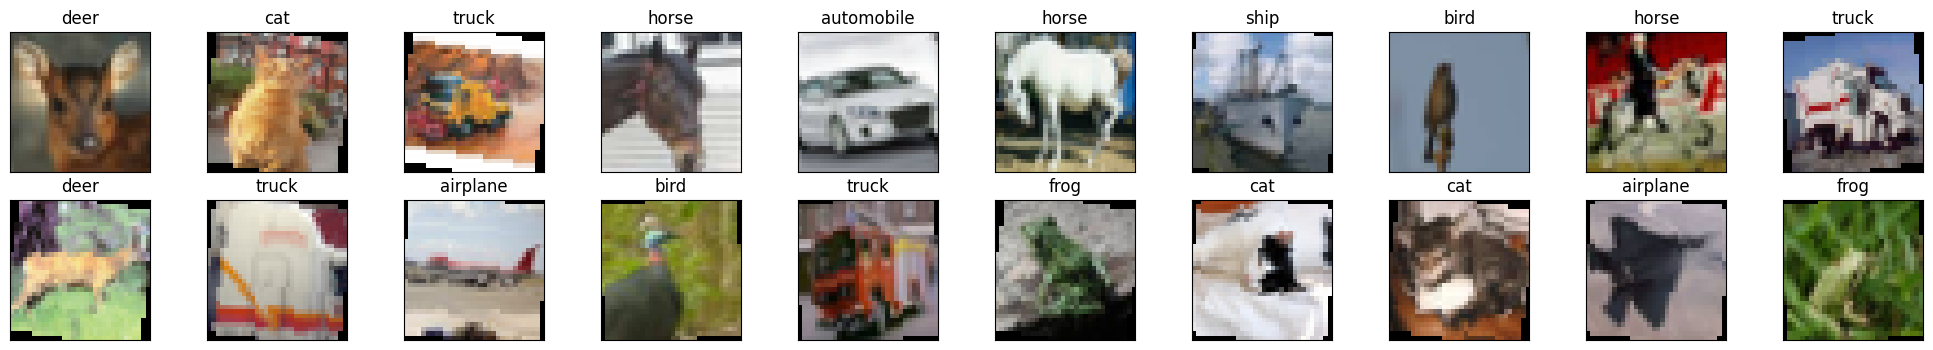

In [70]:
# Plot de um batch de imagens de treino

# Área de plotagem
fig = plt.figure(figsize = (25, 4))

# Loop e print
for idx in np.arange(20):
    
    # Cria os subplots
    ax = fig.add_subplot(2, int(20/2), int(idx+1), xticks=[], yticks=[])
    
    # Desfaz a normalização
    # images[idx]
    imshow(images[idx])
    
    # Coloca o título
    ax.set_title(classes[labels[idx]])

### <font color = "red">Como visualizar mais detalhes da imagem

Aqui, observamos os canais de cores normalizados de vermelho, verde e azul (RGB), como três imagens separadas com intesidade de tons de cinza

In [71]:
# Extraindo os canais de cores

rgb_img = np.squeeze(images[3])
channels = ["Canal Vermelho (Red)", "Canal Verde (Green)", "Canal Azul (Blue)"]

In [73]:
rgb_img[0]

array([[-0.5529412 , -0.6       , -0.41176468, ..., -0.44313723,
        -0.5921569 , -0.56078434],
       [-0.5529412 , -0.5529412 , -0.44313723, ..., -0.38039213,
        -0.5294118 , -0.5294118 ],
       [-0.5529412 , -0.58431375, -0.38039213, ...,  0.07450986,
         0.07450986,  0.14509809],
       ...,
       [ 0.62352943,  0.6313726 ,  0.6313726 , ...,  0.7254902 ,
         0.73333335,  0.7882353 ],
       [ 0.58431375,  0.5686275 ,  0.54509807, ...,  0.827451  ,
         0.8352941 ,  0.8745098 ],
       [ 0.7490196 ,  0.7647059 ,  0.7490196 , ...,  0.7254902 ,
         0.7411765 ,  0.77254903]], dtype=float32)

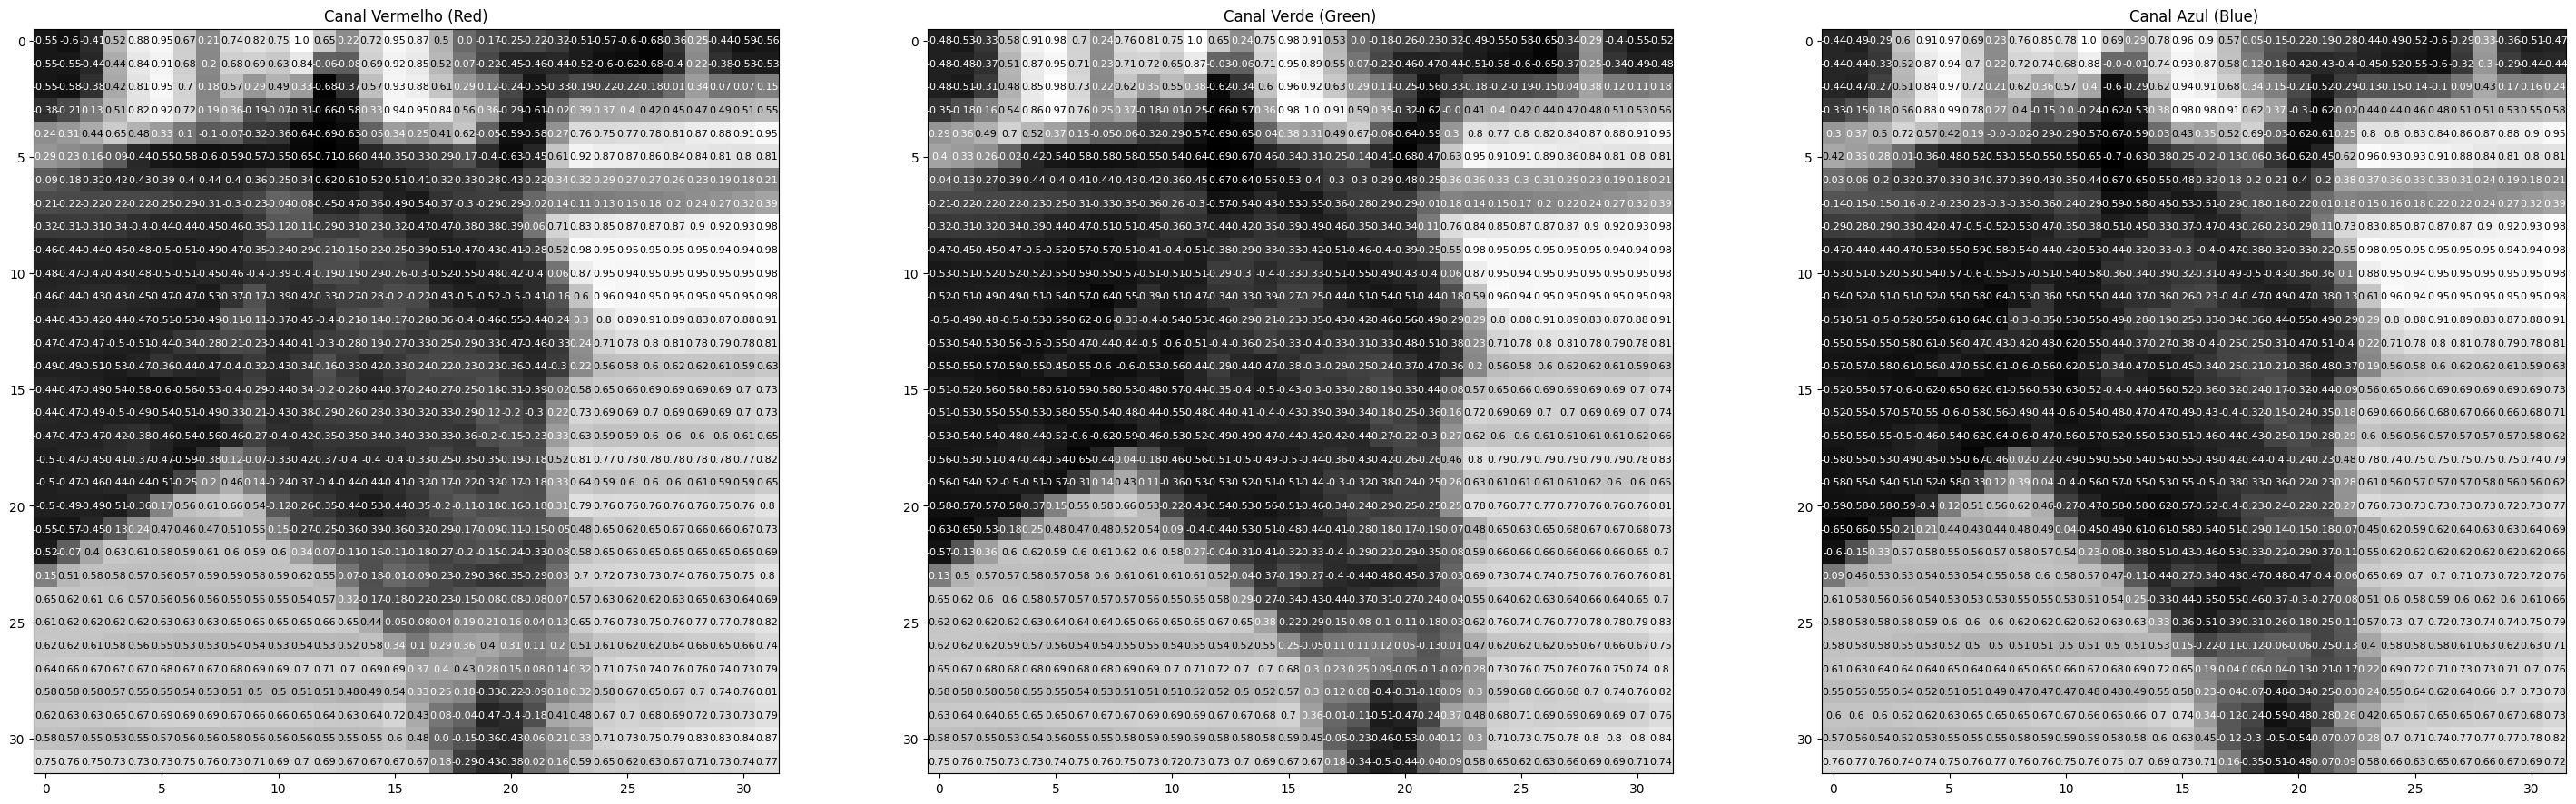

In [76]:
# Loop e print

# Área de plotagem
fig = plt.figure(figsize = (36, 36))

# Loop pelas imagens
for idx in np.arange(rgb_img.shape[0]):

 # Subplot
 ax = fig.add_subplot(1, 3, idx+1)

 # índice
 img = rgb_img[idx]

 # Mostra a imagem em escala de cinza
 ax.imshow(img, cmap = "gray")

 # Título 
 ax.set_title(channels[idx])

 # Largura e altura da imagem
 width, height = img.shape

 # Limite
 thresh = img.max()/2.5

 # Loop 
 for x in range(width):
  for y in range(height):
   val = round(img[x][y],2) if img[x][y] !=0 else 0
   ax.annotate(str(val),
               xy = (y,x),
               horizontalalignment = 'center',
               verticalalignment = 'center',
               size = 8,
               color = 'white' if img[x][y] < thresh else 'black')

# <font color = "green"> Definindo a Arquitetura da REDE Neural

http://pytorch.org/docs/stable/nn.html

Vamos definir uma arquitetura CNN (Convolutional Neural Network). 

* [Camadas convolucionais](https://pytorch.org/docs/stable/nn.html#conv2d), podem ser consideradas como uma pilha de imagens filtradas.

* [Camadas de Maxpool](https://pytorch.org/docs/stable/nn.html#maxpool2d), reduzem o tamanho x-y de uma entrada, mantendo apenas os pixels mais _ativos_ da camada anterior.

* As camadas Linear + Dropout podem evitar sobreajuste e produzir uma saída de 10 dimensões.

In [111]:
# Arquitetura do Modelo

class ModeloCNN(nn.Module):

 # Método Construtor
 def __init__(self):
  super(ModeloCNN, self).__init__()

  # Camada Convolucional de entrada
  self.conv1 = nn.Conv2d(3, 16, 3, padding = 1) # 16 neurônios / Padding coloca zeros nas bordas (camada de contorno) / O 3 é o tamanho do kernel

  # Camada Convolucional oculta
  self.conv2 = nn.Conv2d(16, 32, 3, padding = 1) # 32 neurônios / Padding coloca zeros nas bordas (camada de contorno)

  # Camada Convolucional oculta
  self.conv3 = nn.Conv2d(32, 64, 3, padding = 1) # 64 neurônios / Padding coloca zeros nas bordas (camada de contorno)

  # Camada de Max Pooling
  self.pool = nn.MaxPool2d(2, 2)

  # Camada Totalmente Conectada 1
  self.fc1 = nn.Linear(64 * 4 * 4, 500)

  # Camada Totalmente Conectada 2
  self.fc2 = nn.Linear(500, 10)

  # Camada de Dropout (Regularização)
  self.dropout = nn.Dropout(0.5)


 # Método Foward (Inicialização)
 def forward(self, x):

  # Adiciona uma camada de ativação ReLu para cada camada convolucional
  x = self.pool(F.relu(self.conv1(x)))
  x = self.pool(F.relu(self.conv2(x)))
  x = self.pool(F.relu(self.conv3(x)))

  # Faz o "achatamento" da matriz resultante e cria um vetor -  não posso entregar matriz para classifier
  x = x.view(-1, 64 * 4 * 4)

  # Adiciona uma camada de dorpou para regularização
  x = self.dropout(x)

  # Adiciona a 1ª camada oculta, com função de ativação relu
  x = F.relu(self.fc1(x))

  # Adiciona uma camada dropout para regulaização
  x = self.dropout(x)

  # Adicionna a 2ª camada oculta ( Classificação feita pelo modelo )
  return x

In [112]:
# Cria o modelo

modelo = ModeloCNN()
print(modelo)

ModeloCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


<font color = "red">  

- Kernel é a matriz que será avaliada, no caso 3x3. Multiplica a matriz

- O Stride é quanto eu vou pulando para a direita, ou seja, multiplica a matriz, pula uma coluna para direita, forma outra matriz 3x3 e multiplica. Faz isso até passar por toda imagem, vai dar o resultado da multiplicação do kernel por todos os pixels da matriz, o que da um resultado. Enão você pega o resultado e aplica outra camada de convolução, que fará o mesmo trabalho, com mais neurônios matemáticos


In [113]:
# Movemos o modelo para GPU, se desponível
if train_on_gpu:
 modelo.cuda()

____
# <font color = "green"> Função de Perda (Loss Function)

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

Calcularemos o custo do modelo, para então inciar o back propagation

In [114]:
# Loss Function como categorical cross-entropy

criterion = nn.CrossEntropyLoss() # Geralmente utilizada para classificação de imagens

## <font color = "green"> Otimizador

In [115]:
# Hiperparâmetro
taxa_aprendizado = 0.01

In [116]:
# Otimzador com SGD - Stockate Gradient Descent - Esta etapa é o Back Propagation

optimizer = optim.SGD(modelo.parameters(), lr = taxa_aprendizado)

## <font color = "green"> TREINAMENTO

Lembre-se de observar como a perda em treinamento e validação diminui com o tempo, se a perda em validação aumentar, isso indica um possível sobreajuste (overfitting).

In [117]:
# Números de épocas para treinar o modelo
num_epochs = 30

In [118]:
# Hiperparametro para controlar a mudança do erro em validação
erro_valid_min = np.inf

- <font color = "red">Criando diretório para modelo

In [120]:
import os

# Cria o diretório se não existir
if not os.path.exists('modelos'):
    os.makedirs('modelos')

# Salva o modelo
torch.save(modelo.state_dict(), 'modelos/modelo_final.pt')

- <font color = "red">Treinamento do modelo

In [121]:
%%time
for epoch in range(1, num_epochs + 1):

    # Parâmetros para acompanhar o erro total em treinamento e validação
    erro_treino = 0.0
    erro_valid = 0.0
    
    # Inicia o treinamento do modelo
    modelo.train()
    
    # Loop pelos batches de dados de treino - OU seja - a cada epoch, pegarei baathes de 20 imagens
    for batch_idx, (data, target) in enumerate(loader_treino):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Limpa os gradientes de todas as variáveis otimizadas
        optimizer.zero_grad()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Backward: calcula o gradiente da perda em relação aos parâmetros do modelo
        loss.backward()
        
        # Realiza uma única etapa de otimização (atualização dos parâmetros)
        optimizer.step()
        
        # Atualiza o erro total em treino
        erro_treino += loss.item() * data.size(0)
        
    # Inicia a validação do modelo
    modelo.eval()
    
    # Loop pelos batches de dados de validação
    for batch_idx, (data, target) in enumerate(loader_valid):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Atualiza o erro total de validação
        erro_valid += loss.item() * data.size(0)
    
    # Calcula o erro médio
    erro_treino = erro_treino / len(loader_treino.dataset)
    erro_valid = erro_valid / len(loader_valid.dataset)
        
    # Print
    print('\nEpoch: {} \tErro em Treinamento: {:.6f} \tErro em Validação: {:.6f}'.format(epoch, 
                                                                                         erro_treino, 
                                                                                         erro_valid))
    
    # Salva o modelo sempre que a perda em validação diminuir
    if erro_valid <= erro_valid_min:
        print('Erro em Validação foi Reduzido ({:.6f} --> {:.6f}). Salvando o modelo...'.format(erro_valid_min,
                                                                                                 erro_valid))
        torch.save(modelo.state_dict(), 'modelos/modelo_final.pt')
        erro_valid_min = erro_valid


Epoch: 1 	Erro em Treinamento: 3.434702 	Erro em Validação: 0.756362
Erro em Validação foi Reduzido (inf --> 0.756362). Salvando o modelo...

Epoch: 2 	Erro em Treinamento: 3.382905 	Erro em Validação: 0.702561
Erro em Validação foi Reduzido (0.756362 --> 0.702561). Salvando o modelo...

Epoch: 3 	Erro em Treinamento: 3.353537 	Erro em Validação: 0.695307
Erro em Validação foi Reduzido (0.702561 --> 0.695307). Salvando o modelo...

Epoch: 4 	Erro em Treinamento: 3.312041 	Erro em Validação: 0.682357
Erro em Validação foi Reduzido (0.695307 --> 0.682357). Salvando o modelo...

Epoch: 5 	Erro em Treinamento: 3.274118 	Erro em Validação: 0.688878

Epoch: 6 	Erro em Treinamento: 3.252933 	Erro em Validação: 0.654731
Erro em Validação foi Reduzido (0.682357 --> 0.654731). Salvando o modelo...

Epoch: 7 	Erro em Treinamento: 3.228414 	Erro em Validação: 0.647963
Erro em Validação foi Reduzido (0.654731 --> 0.647963). Salvando o modelo...

Epoch: 8 	Erro em Treinamento: 3.232138 	Erro em Val

## <font color = "red"> Carrega o modelo Final

In [122]:
modelo.load_state_dict(torch.load("modelos/modelo_final.pt"))

<All keys matched successfully>

## <font color = "red"> Testando e Avaliando o Modelo Final

Testamos o modelo treinado em dados nucna vistso anteriormente. Um resultado "bom" será uma CNN que obtenha 70% (ou mais) de precisão nas imagens de teste

In [123]:
# Erro em teste
erro_teste = 0.0

In [124]:
# Controle de acertos do modelo
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [125]:
# Inicia a avaliação do modelo
modelo.eval()

# Loop pelos batches de dados de teste
for batch_idx, (data, target) in enumerate(loader_teste):
    
    # Move os tensores para GPU se disponível
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # Forward
    output = modelo(data)
    
    # Calcula o erro
    loss = criterion(output, target)
    
    # Atualiza o erro em teste
    erro_teste += loss.item() * data.size(0)
    
    # Converte probabilidades de saída em classe prevista
    _, pred = torch.max(output, 1)    
    
    # Compara as previsões com o rótulo verdadeiro
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calcula a precisão do teste para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Erro médio em teste
erro_teste = erro_teste / len(loader_teste.dataset)
print('\nErro em Teste: {:.6f}\n'.format(erro_teste))

# Calcula a acurácia para cada classe
for i in range(10):
    if class_total[i] > 0:
        print('Acurácia em Teste da classe %5s: %2d%% (%2d/%2d)' % (classes[i], 
                                                             100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), 
                                                             np.sum(class_total[i])))
    else:
        print('Acurácia em Teste de %5s:)' % (classes[i]))

# Calcula a acurácia total
print('\nAcurácia em Teste (Total): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct), 
                                                        np.sum(class_total)))


Erro em Teste: 2.894010

Acurácia em Teste da classe airplane: 69% (693/1000)
Acurácia em Teste da classe automobile: 80% (804/1000)
Acurácia em Teste da classe  bird: 59% (599/1000)
Acurácia em Teste da classe   cat: 37% (375/1000)
Acurácia em Teste da classe  deer: 54% (544/1000)
Acurácia em Teste da classe   dog: 67% (674/1000)
Acurácia em Teste da classe  frog: 89% (891/1000)
Acurácia em Teste da classe horse: 78% (785/1000)
Acurácia em Teste da classe  ship: 82% (827/1000)
Acurácia em Teste da classe truck: 82% (823/1000)

Acurácia em Teste (Total): 70% (7015/10000)


## <font color = "red"> Previsões com Modelo treinado

In [142]:
# Obtém um batch de dados de teste
dataiter = iter(loader_teste)
images, labels = next(dataiter)


In [143]:
# Move as imagens para a GPU se disponível
if train_on_gpu:
    images = images.cuda()

In [144]:
# Faz as previsões com o modelo treinado
output = modelo(images)

In [138]:
images = images.detach().cpu().numpy() # Certificando que estão na CPU

In [145]:
# Converte probabilidades de saída em classe prevista
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


Entre parênteses a classe real. Vermelho indica erro do modelo.



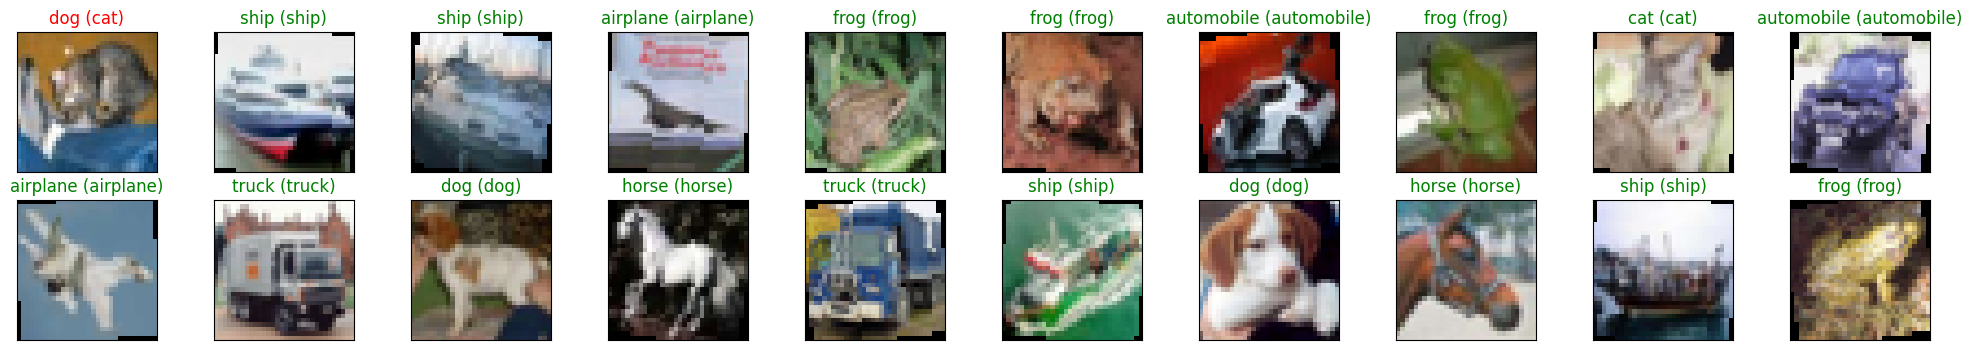

In [146]:
# Plot das previsões
fig = plt.figure(figsize = (25, 4))

print("\nEntre parênteses a classe real. Vermelho indica erro do modelo.\n")

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), int(idx+1), xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
                 color = ("green" if preds[idx] == labels[idx].item() else "red"))

# Final